# Task 1: Factor analysis of a stock return

## Importing Data

In [134]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
np.random.seed(3)
returns=pd.read_excel("stock_returns.xlsx")


factors=pd.read_csv("F-F_Research_Data_Factors.csv")
factors=factors.rename(columns={ factors.columns[0]: "Date" })
#factors['Date'] = pd.to_datetime(factors['Date'],format= '%Y%M:%S' ).dt.time


## Some data transformation

### Converting Daily stock returns to monthly

We assume that in order to calculate the monthly returns, the start and the end date for the period are the first day and last day of the month.

In [135]:
returns["mDate"]=returns["Date"].dt.to_period("M")  # Converting the Date column to monthly dates
returns["return_plus_1"]=returns["Returns"]+1 # adding 1 to calculate the multiplicative factor
groupby_mDate=returns.groupby("mDate")   # grouping the returns by monthly dates 
returns["mReturns"]=groupby_mDate["return_plus_1"].transform(np.product)-1  # using the above group to multiply all the factors for a month
returns=returns.drop(returns.columns[[0,1,3]],axis=1) # removing undrequired columns
returns=returns.drop_duplicates().reset_index(drop=True)  # Resetting the index

In [136]:
returns.head()

,mDate,mReturns
0,1988-01,0.027119
1,1988-02,0.039604
2,1988-03,0.087302
3,1988-04,0.102190
4,1988-05,0.039735


### Extracting dates from the first column of factors

In [137]:
factors["MDate"]=pd.to_datetime(factors["Date"],format="%Y%m")  # extracting dates

factors['MDate']=factors['MDate'].dt.to_period("M")  # Converting the dates into the format same as the returns dataframe

In [138]:
factors.head()

,Date,Mkt-RF,SMB,HML,RF,MDate
0,192607,0.0296,-0.0256,-0.0243,0.0022,1926-07
1,192608,0.0264,-0.0117,0.0382,0.0025,1926-08
2,192609,0.0036,-0.0140,0.0013,0.0023,1926-09
3,192610,-0.0324,-0.0009,0.0070,0.0032,1926-10
4,192611,0.0253,-0.0010,-0.0051,0.0031,1926-11


In [139]:
returns_and_factors=returns.merge(factors,left_on="mDate",right_on="MDate",how="left")  # Merging the returns and factors dataframes

In [140]:
returns_and_factors=returns_and_factors[returns_and_factors["Date"].notnull()]   # Removing all the nas

In [141]:
returns_and_factors=returns_and_factors.drop(returns_and_factors.columns[[2,7]],axis=1)   # removign unrequired columns


In [142]:
returns_and_factors=returns_and_factors.sort_values(by='mDate', ascending=False).reset_index(drop=True)
returns_and_factors = returns_and_factors.rename({'Mkt-RF': 'Mkt_RF'}, axis=1)
returns_and_factors.head()

,mDate,mReturns,Mkt_RF,SMB,HML,RF
0,2023-02,-0.020032,-0.0258,0.0110,-0.0080,0.0034
1,2023-01,0.009150,0.0665,0.0502,-0.0405,0.0035
2,2022-12,-0.024088,-0.0641,-0.0068,0.0132,0.0033
3,2022-11,0.079160,0.0460,-0.0340,0.0138,0.0029
4,2022-10,0.094915,0.0783,0.0009,0.0805,0.0023


## Model Building

In [143]:
result = sm.ols(formula="mReturns ~ Mkt_RF + SMB+HML", data=returns_and_factors).fit()

In [144]:
print(result.params)

Intercept    0.008152
Mkt_RF       0.757042
SMB         -0.497156
HML          0.398842
dtype: float64


In [145]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               mReturns   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     78.18
Date:                Fri, 16 Jun 2023   Prob (F-statistic):           3.70e-40
Time:                        19:25:34   Log-Likelihood:                 689.48
No. Observations:                 422   AIC:                            -1371.
Df Residuals:                     418   BIC:                            -1355.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0082      0.002      3.474      0.0

## Analysis

* We can see that the p values of the coeffiecients and the intercept are less implying that they are significant. 

* The Adjusted R-Squared is around 35% implying that the model is not very good to explain the stock returns.
* The Durbin Watson test statistic is close to 2 implying that there is no autocorrelation. 
* The test statistic for Jarque Bera test is significantly large implying that the residuals are not normally distributed.


* The negative weight of SMB implies that the portfolio is more weighted towards large cap companies.
* Similarly, the beta value of HML implies that the portfolio has more exposure to value stocks (or high Book to Market value stocks).

# Task 3: Portfolio construction

In [146]:
returns=pd.read_csv("port_returns.csv")
returns=returns.rename(columns={ returns.columns[0]: "Date" })
portfolios=pd.read_csv("10_Industry_Portfolios.csv")


In [147]:
returns.head()

,Date,Portfolio returns
0,1926-07,0.010643
1,1926-08,0.029051
2,1926-09,-0.004286
3,1926-10,-0.037112
4,1926-11,0.036685


In [148]:
portfolios.head()

,Unnamed: 0,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
0,192607,0.0145,0.1555,0.0469,-0.0118,0.0290,0.0083,0.0011,0.0177,0.0704,0.0213
1,192608,0.0397,0.0368,0.0281,0.0347,0.0266,0.0217,-0.0071,0.0425,-0.0169,0.0435
2,192609,0.0114,0.0480,0.0115,-0.0339,-0.0038,0.0241,0.0021,0.0069,0.0204,0.0029
3,192610,-0.0124,-0.0823,-0.0363,-0.0078,-0.0458,-0.0011,-0.0229,-0.0057,-0.0263,-0.0284
4,192611,0.0520,-0.0019,0.0410,0.0001,0.0471,0.0163,0.0643,0.0542,0.0371,0.0211


In [149]:
#portfolios_and_returns=pd.concat([returns,portfolios],axis=1)


In [150]:
portfolios["Date"]=returns["Date"]
portfolios=portfolios.drop(portfolios.columns[[0]],axis=1)
#portfolios=portfolios.rename(columns={portfolios.columns[0]: "Date" })
portfolios = portfolios.set_index('Date')
portfolios.head()

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
1926-07,0.0145,0.1555,0.0469,-0.0118,0.0290,0.0083,0.0011,0.0177,0.0704,0.0213
1926-08,0.0397,0.0368,0.0281,0.0347,0.0266,0.0217,-0.0071,0.0425,-0.0169,0.0435
1926-09,0.0114,0.0480,0.0115,-0.0339,-0.0038,0.0241,0.0021,0.0069,0.0204,0.0029
1926-10,-0.0124,-0.0823,-0.0363,-0.0078,-0.0458,-0.0011,-0.0229,-0.0057,-0.0263,-0.0284
1926-11,0.0520,-0.0019,0.0410,0.0001,0.0471,0.0163,0.0643,0.0542,0.0371,0.0211


In [151]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *12
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(12)
    return std, returns

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(10)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=cov_matrix.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=cov_matrix.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

In [152]:
#returns = table.pct_change()
mean_returns = portfolios.mean()
cov_matrix = portfolios.cov()
num_portfolios = 80000
risk_free_rate = 0.00

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.12
Annualised Volatility: 0.16


            NoDur  Durbl  Manuf  Enrgy  HiTec  Telcm  Shops  Hlth   Utils  \
allocation  25.01   1.72   0.82   6.13  10.64  18.54   5.11  26.65   5.09   

            Other  
allocation   0.29  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.11
Annualised Volatility: 0.16


            NoDur  Durbl  Manuf  Enrgy  HiTec  Telcm  Shops  Hlth   Utils  \
allocation  20.43   0.37   5.07  14.22   1.69  20.97    1.7   14.7   20.1   

            Other  
allocation   0.76  


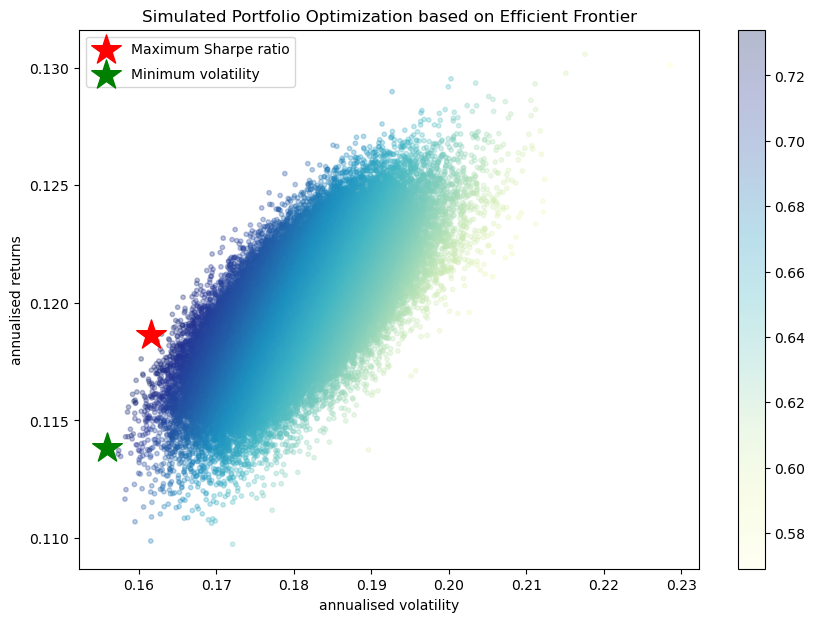

In [153]:

display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [154]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [155]:
import scipy.optimize as sco
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

In [156]:
rs=efficient_return(mean_returns,cov_matrix,0.107)

In [157]:
rs

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.14631105914250248
       x: [ 4.375e-01  1.176e-17  0.000e+00  1.792e-02  0.000e+00
            4.645e-01  8.240e-18  0.000e+00  8.008e-02  8.132e-18]
     nit: 13
     jac: [ 1.450e-01  2.025e-01  1.824e-01  1.435e-01  1.932e-01
            1.475e-01  1.685e-01  1.461e-01  1.467e-01  1.893e-01]
    nfev: 143
    njev: 13

# Task 4

In [158]:
def sim_paths(S, T, r, sigma, steps, N):
  
    #S = Current stock Price
    #T = Time to maturity 
    #r = risk free interest rate
    # sigma = volatility 
   
    dt = T/steps
    ST = np.log(S) +  np.cumsum(((r - sigma**2/2)*dt +\
                              sigma*np.sqrt(dt) * \
                              np.random.normal(size=(steps,N))),axis=0)
    return np.exp(ST)



S = 98 #stock price 
K = 100 # strike
T = 1 # time to maturity
r = 0.02 # risk free risk in annual %
sigma = 0.17 # annual volatility in %
steps = 100 # time steps


N=10000
Sim_spot= sim_paths(S, T, r,sigma, steps, N)
payoffs = np.maximum(Sim_spot[-1]-K, 0)
option_price = np.exp(-r*T)*np.mean(payoffs)
print(f"Call option price is {option_price}")


Call option price is 6.689060836589971
